## Test Batch Normalization on tissues


**Question:** How does combat batch normalization algorithms perform on adjacent section tissues stained with the same panel, when training with unmatched cores?

**Samples:** 
- TMA: Purchased from biomax: https://www.biomax.us/tissue-arrays/Breast/BR1506
- Adjacent Sections: BM-Her2N75-15, BM-Her2N75-17, BM-Her2N75-18 (section 16 skipped.)
- Scenes: (i.e. TMA cores) 
  - 17: ER+/HER2+, immune rich. 
  - 49: ER+/HER2+
  - 59: HER2+ immune rich

**Method**: We performed combat normalization using unlike tissues as training set (different cores in training set and all cores in testing set). We visualized the resulting histograms.

In [1]:
#load libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import copy
import seaborn as sns
import importlib
import scanpy as sc
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale, minmax_scale, StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib as mpl
mpl.rc('figure', max_open_warning = 0)
#os.chdir('/home/groups/graylab_share/OMERO.rdsStore/engje/Data/cmIF')
from mplex_image import visualize as viz, process, preprocess, normalize
np.random.seed(1202)

In [2]:
#change to correct directory
#os.chdir('/home/groups/graylab_share/OMERO.rdsStore/engje/Data/cycIF_ValidationStudies/cycIF_Validation')
codedir=os.getcwd()
rootdir = f'{codedir}/Data/'
datadir = f'{codedir}/Data/filtered_data'
os.chdir(datadir)
%matplotlib inline

In [ ]:
# load data
df=pd.read_csv(f'20201229_BM-Her2N75-15-17-18_MeanIntensity.csv',index_col=0)
df.rename({'slide':'batch'},axis=1,inplace=True)

In [ ]:
#importlib.reload(normalize)

In [ ]:
def plot_histograms(df_norm,df,s_train,s_tissue):
    df_norm['batch'] = [item.split('_')[0] for item in df_norm.index]
    bins=50
    for s_marker in df_norm.columns[df_norm.dtypes=='float64']:
        print(s_marker)
        fig,ax=plt.subplots(2,1,figsize = (5,5))
        for idxs, s_batch in enumerate(sorted(set(df_norm.batch))):
            df_batch = df_norm[(df_norm.batch==s_batch)].loc[:,s_marker] 
            if len(df_batch.dropna()) == 0:
                continue
            ax[0].hist(df.loc[df.index.str.contains(s_batch),s_marker],bins=bins,alpha=0.4, color=f'C{idxs}',label=s_batch)
            ax[1].hist(df_batch,bins=bins,alpha=0.4, color=f'C{idxs}',label=s_batch)
            ax[0].set_yscale('log')
            ax[1].set_yscale('log')
            ax[0].set_title(f'{s_marker.split("_")[0]}: Raw Data {s_train}')
            ax[1].set_title(f'{s_marker.split("_")[0]}: Combat')
            ax[0].legend()
        plt.tight_layout()
        fig.savefig(f'{rootdir}/20201228/Different_Scaling_combat_training_{s_train}_{s_marker}_{s_tissue}.png')


In [ ]:
#all cores
data = df.loc[:,df.dtypes=='float64'].T
batch = df.batch
gamma_star, delta_star = normalize.combat_fit(data, batch)
#transform
bayesdata = normalize.combat_transform(data,batch,gamma_star, delta_star)
df_norm=bayesdata.T
s_train='all'
s_tissue = 'all'
plot_histograms(df_norm,df,s_train,s_tissue)

## Training combat with controls

How sensitive is the combat algorithm to the inputs that determine the parameters?

- Can different tissues in each batch be used to fit combat?
- Can a limited set of tissues be used to fit combat?
- Or, should the set of tissues used to fit combat be very similar to those it is applied to?

In [ ]:
lls_batch = [['BM-Her2N75-15', 'BM-Her2N75-17', 'BM-Her2N75-18'],
            [ 'BM-Her2N75-17', 'BM-Her2N75-18','BM-Her2N75-15'],
            [ 'BM-Her2N75-18','BM-Her2N75-15', 'BM-Her2N75-17']]
ls_scene = sorted(set(df.scene))

In [ ]:
#normalize with different training sets
for idxx, ls_batch in enumerate(lls_batch):
    data = pd.DataFrame()
    for idx, s_batch in enumerate(ls_batch):
        s_scene = ['scene017', 'scene049', 'scene059'][idx]
        data = data.append(df.loc[((df.scene==s_scene)&(df.batch==s_batch)),:])   
    #fit training set
    gamma_star, delta_star = normalize.combat_fit(data.loc[:,data.dtypes=='float64'].T, data.batch)
    #transform full data set
    bayesdata = normalize.combat_transform(df.loc[:,df.dtypes=='float64'].T,df.batch,gamma_star, delta_star)
    df_norm=bayesdata.T
    s_train = "_".join([(item + ls_scene[idx]).split('-')[-1].replace('scene','s') for idx, item in enumerate(ls_batch)])
    s_tissue = 'all'
    plot_histograms(df_norm,data,s_train,s_tissue)
    df_norm.sample(5400,random_state=3).to_csv(f'20201229-{idxx}_BM-Her2N75_SampledMeanIntensity_diff_train.csv')

In [ ]:
#normalize with same training sets
for idx, ls_batch in enumerate(lls_batch):
    s_scene = ['scene017', 'scene049', 'scene059'][idx]
    data = pd.DataFrame()
    for s_batch in ls_batch:   
        data = data.append(df.loc[((df.scene==s_scene)&(df.batch==s_batch)),:])   
    #fit training set
    gamma_star, delta_star = normalize.combat_fit(data.loc[:,data.dtypes=='float64'].T, data.batch)
    #transform full data set
    bayesdata = normalize.combat_transform(df.loc[:,df.dtypes=='float64'].T,df.batch,gamma_star, delta_star)
    df_norm=bayesdata.T
    s_train = "_".join([(item + s_scene).split('-')[-1].replace('scene','s') for idx, item in enumerate(ls_batch)])
    s_tissue = 'all'
    plot_histograms(df_norm,data,s_train,s_tissue)
    df_norm.sample(5400,random_state=3).to_csv(f'20201229-{idx}_BM-Her2N75_SampledMeanIntensity_same_train.csv')


In [ ]:
#normalize with sampled training sets
ls_date = ['20201207','20201208','20201209']
for idx, s_date in enumerate(ls_date):
    data = pd.read_csv(f'{s_date}_BM-Her2N75-15-17-18_SampledMeanIntensity_raw.csv',index_col=0)
    data['batch'] = [item.split('_')[0] for item in data.index]
    #fit training set
    gamma_star, delta_star = normalize.combat_fit(data.loc[:,data.dtypes=='float64'].T, data.batch)
    #transform full data set
    bayesdata = normalize.combat_transform(df.loc[:,df.dtypes=='float64'].T,df.batch,gamma_star, delta_star)
    df_norm=bayesdata.T
    s_train = s_date
    s_tissue = 'all'
    plot_histograms(df_norm,data,s_train,s_tissue)
    df_norm.sample(5400,random_state=3).to_csv(f'20201229-{idx}_BM-Her2N75_SampledMeanIntensity_sampled_train.csv')


## RESTORE methods: Results

What is the best practice for restore normalization?

- Global or local thresholds? - **Local slightly better but neither very good**
- Raw data or arcsinh transformation? - **No difference**
- Divide by threshold or scale values above threshold? - **Scale gives good normaliztion, but not as good as combat**

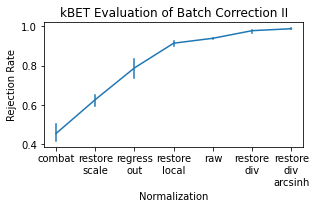

In [7]:
#os.chdir(filterdir)
df_file = pd.DataFrame(index=os.listdir())
df_file = df_file[df_file.index.str.contains('BM-Her2N75-15-17-18_kbet_')]
#ls_train = ['diff_train','raw', 'same_train', 'sampled_train','raw_combat']
ls_method = ['raw', 'raw_combat', 'raw_regress_out', 'restore_local', 'restore_div','restore_div_arcsinh', 'restore_scale']#,'raw_restore_combat' 'raw_restore','raw_restore_regress_out',

#add mean kbet
for s_file in df_file.index:
    df = pd.read_csv(s_file,index_col=0)
    df_file.loc[s_file,'mean_kbet'] = df.loc['mean','kBET.observed']
df_file['norm'] = [item.split('kbet_')[1].split('.csv')[0] for item in df_file.index]
df_file = df_file[df_file.norm.isin(ls_method)]
ls_index= df_file.groupby('norm').mean_kbet.mean().sort_values().index
df_file.groupby('norm').mean_kbet.mean().sort_values()
df_file['Norm'] = pd.Categorical(
    df_file['norm'], 
    categories=ls_index.tolist(), 
    ordered=True
)
%matplotlib inline
fig, ax = plt.subplots(figsize=(4.5,3))
df_plot = df_file.sort_values('Norm')
sns.lineplot(data=df_plot,x='norm',y='mean_kbet',ax=ax,err_style='bars')
labels = [item.replace('raw_','').replace('_','\n') for item in ls_index.tolist()]
ax.set_xticks(range(len(df_file.groupby('norm').mean_kbet)))
ax.set_xticklabels(labels,rotation=0)
ax.set_ylabel('Rejection Rate')
ax.set_xlabel('Normalization')
ax.set_title('kBET Evaluation of Batch Correction II')
fig.set_tight_layout(True)
plt.tight_layout
fig.savefig(f'{rootdir}/20201228/BatchEffectII.png',dpi=200)

In [8]:
df_plot.groupby('Norm').mean()

,mean_kbet
Norm,
raw_combat,0.454364
restore_scale,0.626889
raw_regress_out,0.788704
restore_local,0.914633
raw,0.939605
restore_div,0.978421
restore_div_arcsinh,0.988306


In [9]:
df_plot.groupby('Norm').std()

,mean_kbet
Norm,
raw_combat,0.045267
restore_scale,0.028187
raw_regress_out,0.048837
restore_local,0.015092
raw,0.002303
restore_div,0.008651
restore_div_arcsinh,0.003616


## Training combat with controls: Results

How sensitive is the combat algorithm to the inputs that determine the parameters?

- Can different tissues in each batch be used to fit combat? - **No, kbet rejection rate is near 1**
- Can a limited set of tissues be used to fit combat? - **Varies, kbet rejection from 0.85 to 1, depending on training tissue**
- Or, should the set of tissues used to fit combat be very similar to those it is applied to? - **Yes, lowest kbet rejection rate**

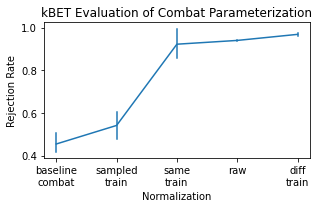

In [3]:
#add mean kbet
df_file = pd.DataFrame(index=os.listdir())
df_file = df_file[df_file.index.str.contains('BM-Her2N75-15-17-18_kbet_')]
ls_train = ['diff_train','raw', 'same_train', 'sampled_train','raw_combat']
for s_file in df_file.index:
    df = pd.read_csv(s_file,index_col=0)
    df_file.loc[s_file,'mean_kbet'] = df.loc['mean','kBET.observed']
df_file['norm'] = [item.split('kbet_')[1].split('.csv')[0] for item in df_file.index]
df_file = df_file[df_file.norm.isin(ls_train)]
ls_index= df_file.groupby('norm').mean_kbet.mean().sort_values().index
df_file.groupby('norm').mean_kbet.mean().sort_values()
df_file['Norm'] = pd.Categorical(
    df_file['norm'], 
    categories=ls_index.tolist(), 
    ordered=True
)
%matplotlib inline
fig, ax = plt.subplots(figsize=(4.5,3))
df_plot = df_file.sort_values('Norm')
sns.lineplot(data=df_plot,x='norm',y='mean_kbet',ax=ax,err_style='bars')
labels = [item.replace('raw_','baseline_').replace('_','\n') for item in ls_index.tolist()]
ax.set_xticks(range(len(df_file.groupby('norm').mean_kbet)))
ax.set_xticklabels(labels,rotation=0)
ax.set_ylabel('Rejection Rate')
ax.set_xlabel('Normalization')
ax.set_title('kBET Evaluation of Combat Parameterization')
fig.set_tight_layout(True)
plt.tight_layout
fig.savefig(f'{rootdir}/20201228/BatchEffect_CombatParam.png',dpi=200)

In [5]:
df_plot.groupby('Norm').mean()

,mean_kbet
Norm,
raw_combat,0.454364
sampled_train,0.541290
same_train,0.921914
raw,0.939605
diff_train,0.967994


In [6]:
df_plot.groupby('Norm').std()

,mean_kbet
Norm,
raw_combat,0.045267
sampled_train,0.063714
same_train,0.068492
raw,0.002303
diff_train,0.008947
